In [8]:
import os
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from ase.db import connect
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from itertools import groupby
import random
import logging
from src import data_proc
import multiprocessing as mp
from trainer import Trainer
from torch.utils.data import DataLoader, random_split
from model_elec import CLIP, CLIPConfig, SeqNetConfig
def set_seed(seed):
    random.seed(seed)       
    np.random.seed(seed)    
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) 
set_seed(42)

logging.basicConfig(format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
                    datefmt="%m/%d/%Y %H:%M:%S",
                    level=logging.INFO)
logger = logging.getLogger(__name__)

class CrystalDataset(Dataset):
    def __init__(self, db_path):
        self.db = connect(db_path)
        self.entries = list(self.db.select())

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        tmp = self.entries[idx]
        atoms = tmp.toatoms()
        try:
            atom_feature = data_proc.get_crystal_path_muhead(ase_obj=True, stru=atoms)
            target = torch.tensor(tmp.data['dielectric'], dtype=torch.float32)
            atom_feature = torch.tensor(atom_feature, dtype=torch.float32)
            return atom_feature, target
        except ValueError as e:
            print(f"Skipping structure {idx} due to error: {e}")
            return None 


def collate_fn(batch):
    """
    Custom collate function that handles skipping None samples.
    """
    batch = [b for b in batch if b is not None] 
    if len(batch) == 0:
        return None 
    atom_features, targets = zip(*batch)
    max_atoms = max(feat.shape[1] for feat in atom_features)
    batch_size = len(atom_features)
    num_heads, embed_dim = atom_features[0].shape[0], atom_features[0].shape[2]

    padded_features = torch.zeros((batch_size, num_heads, max_atoms, embed_dim), dtype=torch.float32)
    attention_masks = torch.zeros((batch_size, num_heads, max_atoms), dtype=torch.float32)
    for i, feat in enumerate(atom_features):
        num_atoms = feat.shape[1]
        padded_features[i, :, :num_atoms, :] = feat
        attention_masks[i, :, :num_atoms] = 1 
    targets = torch.stack(targets)
    return padded_features, attention_masks, targets

device = 'cpu'
numEpochs = 500
embeddingSize = 384  # emb design
batchSize = 128
blockSize = 31
num_workers = 4
dataInfo = 'Path_GRU'
addr = './Savemodels/'
fName = '{}.txt'.format(dataInfo)
ckptPath = '{}/{}.pt'.format(addr, fName.split('.txt')[0])
dataset = CrystalDataset("/data/home/hzw1010/suth/elec_gw/dbs/clean.db")
train_size = int(0.75 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=99999, pin_memory=False,shuffle=True, collate_fn=collate_fn, drop_last=False)
val_dataloader   = DataLoader(val_dataset, batch_size=batchSize,pin_memory=False,shuffle=False, collate_fn=collate_fn, drop_last=False)
test_dataloader  = DataLoader(test_dataset,batch_size=99999,pin_memory=False,shuffle=False, collate_fn=collate_fn, drop_last=False)
config = CLIPConfig(block_size=blockSize, n_embd=embeddingSize)
model = CLIP(config)

01/15/2025 19:15:59 - INFO - model_elec -   Number of parameters: 5.832058e+06


In [9]:
model.load_state_dict(torch.load(ckptPath))
model = model.to(device)

/tmp/ipykernel_1802528/3762480137.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckptPath))


/data/home/hzw1010/anaconda3/envs/elec/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


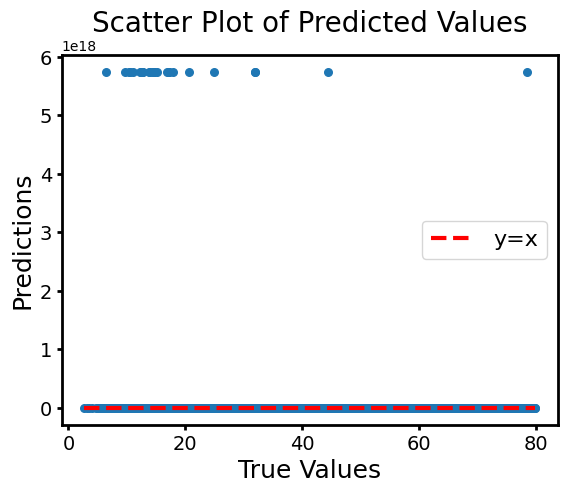

accuracy: -inf with top1


: 

In [10]:
def schmidt_orthogonalization(vectors):
    vectors = vectors.reshape(3, 3)
    diagonal_elements = np.diagonal(vectors)
    ele = np.mean(diagonal_elements)
    return ele

@torch.no_grad()
def sample_from_model(model, target="elec", atoms="stru",test=False,topn=1):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    device = 'cpu'
    target = target.to(device)
    atoms = atoms.to(device)
    model = model.to(device)
    N = len(target)
    to_model_target = target.repeat(1, 3, 3) 
    _, predicts, _ = model(atoms, to_model_target)
    target = torch.exp(target) - 1e-8
    predicts = predicts.cpu()
    topN = topn
    targets = torch.tensor(np.arange(N))
    _, indx = predicts.topk(topN, 0)
    indx = indx.t()
    indx = indx.cpu().numpy().tolist()
    vals = []
    for idxs in indx:  # 这个indx是距离最近的top5的那五个的索引
        val = [schmidt_orthogonalization(target[i, :].cpu().numpy()) for i in idxs]
        vals.append(val)
    vals = np.array(vals)
    if test:
        accuracy_sum = 0
        targets = targets.cpu().numpy()
        judge = torch.nn.MSELoss(reduce=True, size_average=True)
        error_diag = []
        error_diag_mae = []
        ground_truth = []
        best_pred = []
        results_for_csv = []
        for i in range(N):
            if schmidt_orthogonalization(target[i, :].cpu().numpy()) > 80:
                continue
            top3_captions = [indx[i][j] for j in range(len(indx[i]))]
            err = [judge(target[i, :], target[j, :]).cpu().numpy() for j in top3_captions]
            err_diag = [(schmidt_orthogonalization(target[i, :].cpu().numpy()) - schmidt_orthogonalization(target[j, :].cpu().numpy())) ** 2 for j in top3_captions]
            err_diag_mae = [
                abs(schmidt_orthogonalization(target[i, :].cpu().numpy()) - schmidt_orthogonalization(target[j, :].cpu().numpy()))
                for j in top3_captions]
            error_diag.append(np.min(err_diag))
            error_diag_mae.append(np.min(err_diag_mae))
            gt = schmidt_orthogonalization(target[i, :].cpu().numpy())
            ground_truth.append(gt)
            best_pred.append(schmidt_orthogonalization(target[top3_captions[np.argmin(err_diag)], :].cpu().numpy()))
            predictions = [schmidt_orthogonalization(target[j, :].cpu().numpy()) for j in top3_captions]
            results_for_csv.append([gt] + predictions)
            import csv
        if topn == 10:
            with open('results.csv', mode='w', newline='') as file:
                writer = csv.writer(file)
                header = ['ground_truth'] + [f'top{i+1}_prediction' for i in range(len(top3_captions))]
                writer.writerow(header)
                writer.writerows(results_for_csv)
                if np.min(err) <= 1.5:
                    accuracy_sum += 1

        best_pred = np.array(best_pred)
        ground_truth = np.array(ground_truth)
        rss = np.sum((ground_truth - best_pred) ** 2)
        tss = np.sum((ground_truth - np.mean(ground_truth)) ** 2)
        r2 = 1 - (rss / tss)
        import matplotlib.pyplot as plt
        plt.scatter(ground_truth, best_pred, s=30)
        plt.plot([min(ground_truth), max(ground_truth)],
                [min(ground_truth), max(ground_truth)], 'r--', label='y=x',  linewidth=3)
        plt.xlabel('True Values', fontsize=18)
        plt.ylabel('Predictions', fontsize=18)
        plt.title('Scatter Plot of Predicted Values', fontsize=20)
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_linewidth(2) 
        ax.tick_params(width=2)
        plt.legend(fontsize=16)
        plt.tick_params(axis='both', which='major', labelsize=14)
        plt.savefig('test_set.svg', format='svg')
        plt.show()
        return r2

for topn in [1,3,5]:
    for i, (x, _, y)  in enumerate(train_dataloader):  
        # y = y.repeat(1, 3, 3) 
        # x = x[:len(feas_test), :, :, :]      # x是crystal，y是elec
        acc = sample_from_model(model, y, x, True,topn)  # 先进去的是elec
        print('accuracy: {} with top{}'.format(acc,topn))